<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%92%D0%BE%D0%B7%D0%B2%D1%80%D0%B0%D1%82_%D0%BA_%D0%BB%D0%BE%D1%81%D1%81%D1%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-44d_izhg
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-44d_izhg
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=65fa0200fc16dc166a4012af815323cb29748cb349dd788df91a205b74fc8fa7
  Stored in directory: /tmp/pip-ephem-wheel-cache-yr10qma_/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [2]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

from sklearn.preprocessing import StandardScaler 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_vkl_22.11.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [3]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.539882,4.496876,10.840267,6.937616
2010-01-05,6.551187,5.005957,10.896401,7.396526
2010-01-06,6.446983,4.798555,10.840267,7.673220
2010-01-07,6.435065,4.939965,11.401575,7.868933
2010-01-08,6.477847,4.845690,11.647147,7.889179
...,...,...,...,...
2020-11-19,118.639999,12.790000,9.660000,8.820000
2020-11-20,117.339996,12.530000,9.760000,8.740000
2020-11-23,113.849998,13.560000,10.070000,8.860000


# Алгоритм распределения

In [4]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)             # собираем входы в гусеницу
    y = ((d+1).apply(np.log).rolling(lag).sum().applymap(np.exp)-1).shift(1-lag)    # считаем выход на обучении (через сумму логарифмов и возвращаем экспонентой)
    xy = pd.concat([y,X],axis=1).dropna()                                           # сцепляем выход и входы. Убираем не числа
    y = xy.iloc[-learnLen:,:n]                                                      # вырезаем выход
    X = xy.iloc[-learnLen:,n:]                                                      # вырезаем входы
    
    ss_model = StandardScaler().fit(X)                                              # входное нормаированеи учим

    # функция потерь
    # с отрывом от равновесной стратегии
    def loss_function(y_true, y_pred):
        return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n+1,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
    
    learn_res = model.fit(ss_model.transform(X), y, 
                          epochs=1000,
                          validation_split=0.2,
                          verbose=False,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(ss_model.transform(X))[-1,:-1]

    return weights

dData = data.to_returns()
t=1000

wts = []

for n in range(20):
    weights = predWeights(dData[:t])
    wts.append(weights)
    print(weights,1-sum(weights))

wts = np.array(wts)

print('---------------')
print(wts.mean(axis=0))                 # среднее
print(np.quantile(wts,q=0.5,axis=0))    # половинный квантиль

[0.06371493 0.64380336 0.06054459 0.19902974] 0.03290737792849541
[0.03345888 0.6404235  0.03961052 0.24662802] 0.03987910598516464
[0.01609021 0.6283276  0.08424617 0.21301384] 0.05832217074930668
[0.02134025 0.26358697 0.15549736 0.44593394] 0.11364148557186127
[0.11576752 0.1448141  0.334901   0.31566584] 0.08885153383016586
[0.08729227 0.74724734 0.02603127 0.10715285] 0.032276272773742676
[0.02174773 0.8341159  0.01202273 0.08993483] 0.04217878542840481
[0.16116506 0.08514068 0.16958416 0.3735867 ] 0.21052339673042297
[0.04214285 0.494474   0.12975675 0.30542243] 0.02820398285984993
[0.03071748 0.7583287  0.01264876 0.14977838] 0.04852669779211283
[0.04153419 0.60891724 0.04058291 0.24884734] 0.06011832505464554
[0.04580741 0.50002825 0.14970124 0.26008588] 0.044377222657203674
[0.06453062 0.19033611 0.38142818 0.1985822 ] 0.165122888982296
[0.28885207 0.05591976 0.10760676 0.29481396] 0.25280745327472687
[0.10071304 0.15171508 0.13023688 0.5907205 ] 0.026614516973495483
[0.082688

In [5]:
np.quantile(wts,q=0.5,axis=0)

array([0.06412277, 0.39518325, 0.09050359, 0.28752539])

In [6]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        wts = []

        for _ in range(5):

            weights = predWeights(d,
                                    lookback=self.lookback,
                                    lag=self.lag,
                                    learnLen=self.learnLen,
                                    reg=np.power(10,self.reg),
                                    min_delta=np.power(10,self.min_delta),
                                    lr=np.power(10,self.lr),
                                    hl=self.hl,
                                    doRate=self.doRate)

            wts.append(weights)

        weights = np.mean(wts,axis=0)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [7]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    
    d = dData[t:(t+lag)].values                # данные
    
    covar = np.cov(d,rowvar=False)
    mean = np.mean(d,axis=0)
    
    var = np.dot(np.dot(weights, covar), weights)
    
    weights_r = np.ones_like(weights) / covar.shape[0]
    var_r = np.dot(np.dot(weights_r, covar), weights_r)

    koef = np.dot(mean,weights) / np.sqrt(var)
    koef_r = np.dot(mean,weights_r) / np.sqrt(var_r)
    
    # print(koef,koef_r)

    return koef - koef_r

## Создание модели

In [8]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,300),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(10,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [17]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  30537 {'quality': 0.03341519212260942, 'lookback': 278, 'learnLen': 182, 'reg': -0.810000000000132, 'min_delta': -7.0, 'lr': -2.1400000000001036, 'hl': 887, 'lag': 64, 'doRate': 0.17}
finish -  30547 {'quality': 0.19940951350799802, 'lookback': 273, 'learnLen': 200, 'reg': -1.8200000000001104, 'min_delta': -6.280000000000015, 'lr': -2.5100000000000957, 'hl': 753, 'lag': 68, 'doRate': 0.11}
finish -  30557 {'quality': -0.23525957582754084, 'lookback': 296, 'learnLen': 175, 'reg': -0.9900000000001281, 'min_delta': -6.560000000000009, 'lr': -2.0900000000001047, 'hl': 860, 'lag': 65, 'doRate': 0.08}
30563 {'quality': 0.035027567407027005, 'lookback': 267, 'learnLen': 226, 'reg': -1.090000000000126, 'min_delta': -6.06000000000002, 'lr': -1.3900000000001196, 'hl': 777, 'lag': 60, 'doRate': 0.04}
finish -  30567 {'quality': 0.05285367619024114, 'lookback': 263, 'learnLen': 195, 'reg': -0.8600000000001309, 'min_delta': -7.0, 'lr': -1.4500000000001183, 'hl': 903, 'lag': 72, 'doRate': 

Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f2155372ef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1279, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


30624 {'quality': -0.11217201244631814, 'lookback': 259, 'learnLen': 205, 'reg': -1.0700000000001264, 'min_delta': -6.940000000000001, 'lr': -2.500000000000096, 'hl': 875, 'lag': 65, 'doRate': 0.02}
finish -  30627 {'quality': -0.03956648889124367, 'lookback': 298, 'learnLen': 209, 'reg': -0.8900000000001302, 'min_delta': -5.750000000000027, 'lr': -2.400000000000098, 'hl': 755, 'lag': 50, 'doRate': 0.09999999999999999}
finish -  30637 {'quality': -0.3324459368663394, 'lookback': 255, 'learnLen': 212, 'reg': -1.37000000000012, 'min_delta': -6.010000000000021, 'lr': -1.510000000000117, 'hl': 911, 'lag': 55, 'doRate': 0.09}
finish -  30647 {'quality': 0.059695400467953415, 'lookback': 267, 'learnLen': 203, 'reg': -0.9200000000001296, 'min_delta': -6.880000000000003, 'lr': -1.9500000000001076, 'hl': 807, 'lag': 67, 'doRate': 0.11}
30656 {'quality': 0.08245323960076523, 'lookback': 267, 'learnLen': 198, 'reg': -0.9900000000001281, 'min_delta': -6.110000000000019, 'lr': -2.4600000000000968, 

KeyboardInterrupt: ignored

## Графики

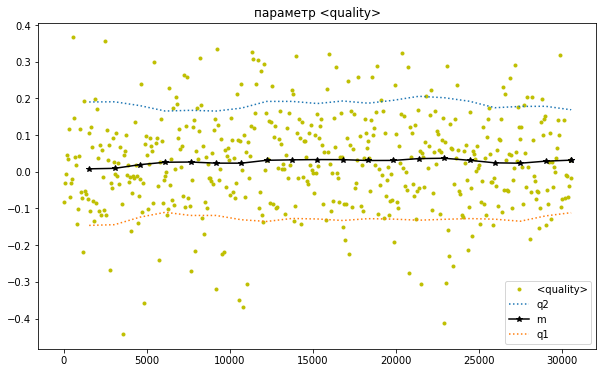

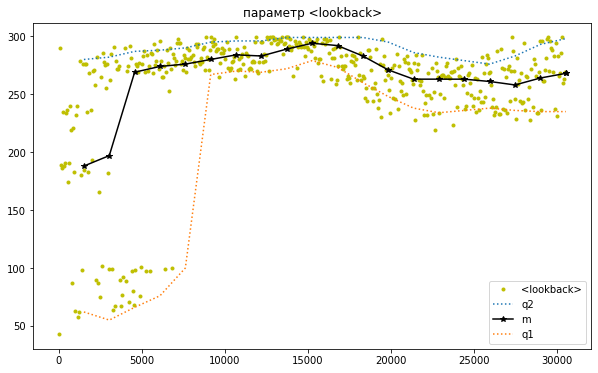

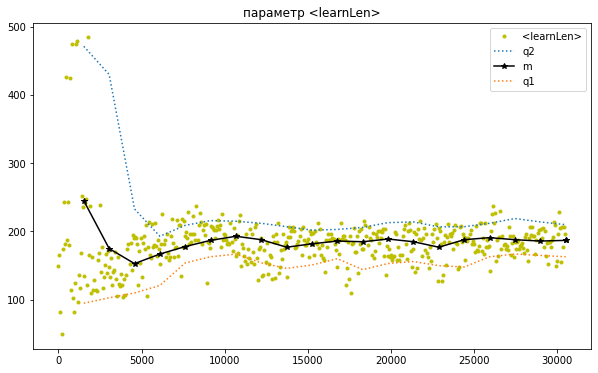

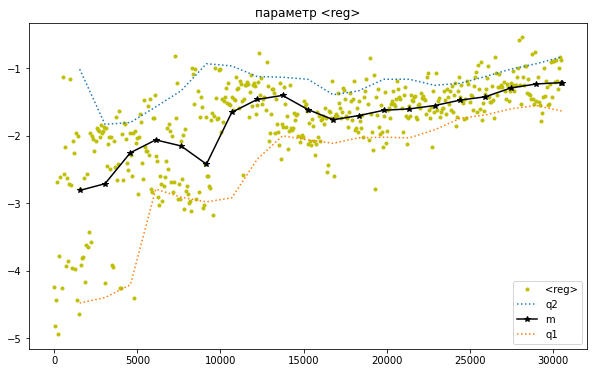

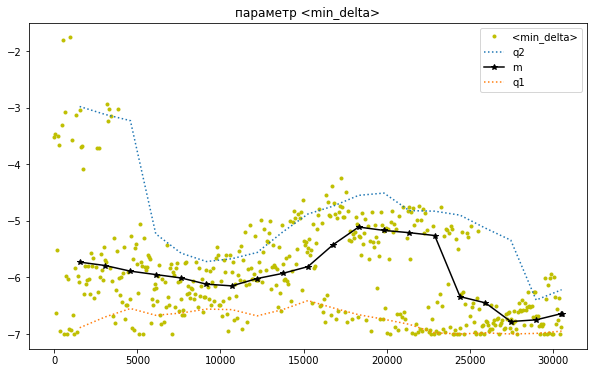

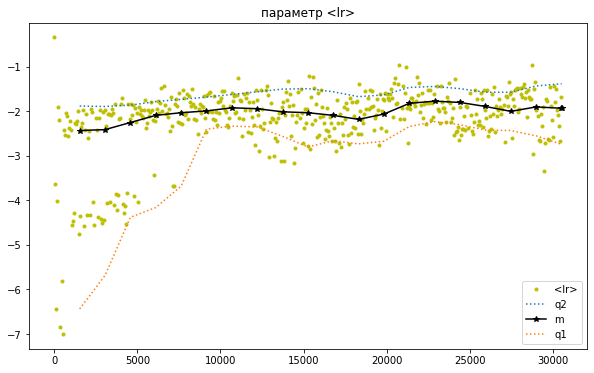

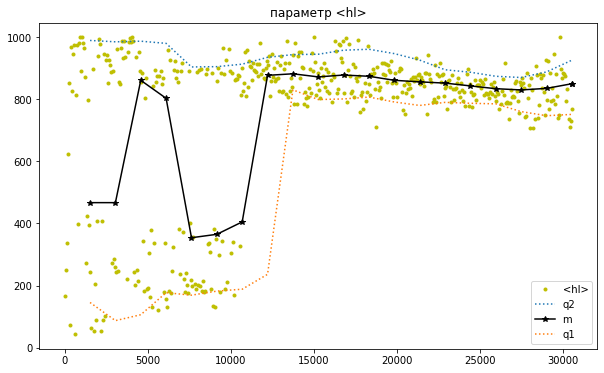

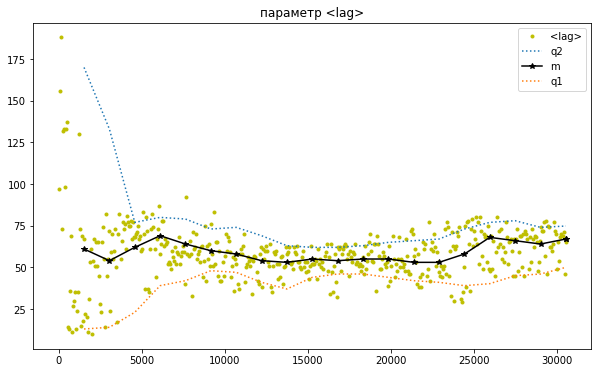

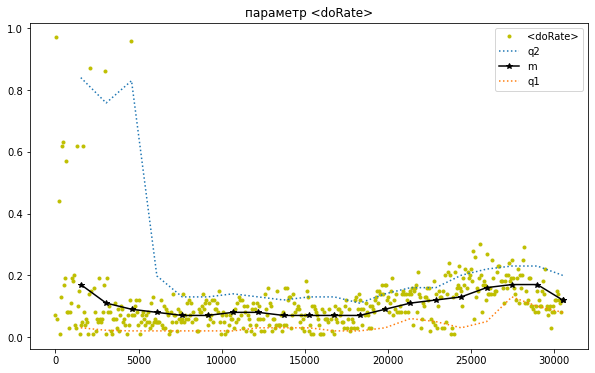

In [10]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [11]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.09,
 'hl': 824,
 'lag': 64,
 'learnLen': 187,
 'lookback': 276,
 'lr': -1.980000000000107,
 'min_delta': -6.4600000000000115,
 'reg': -1.1000000000001258}

# Прогон лучшей

In [12]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:23равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

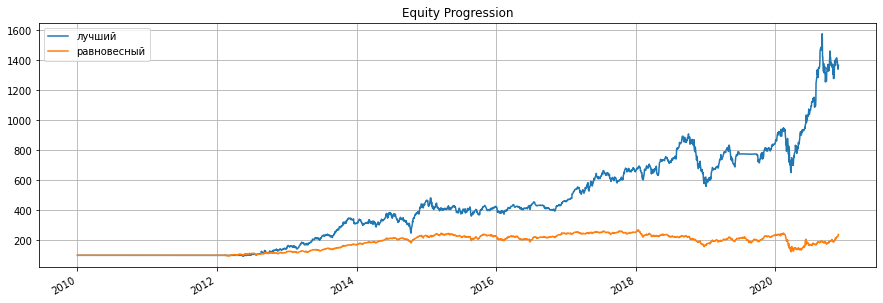

In [13]:
res_best.plot()
plt.grid()

## график распределения долей

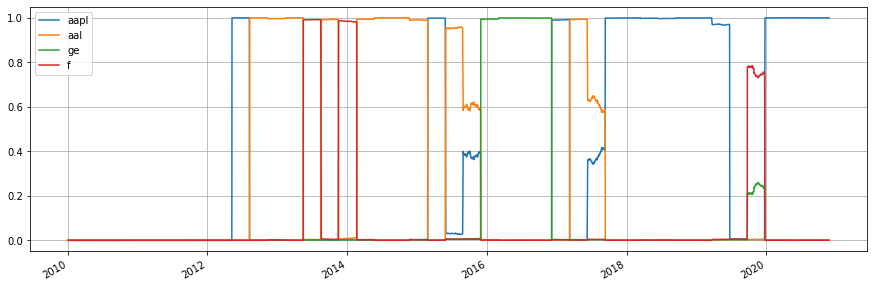

In [14]:

res_best.get_security_weights().plot(figsize=(15,5))
plt.grid()


## график распределения свободной доли

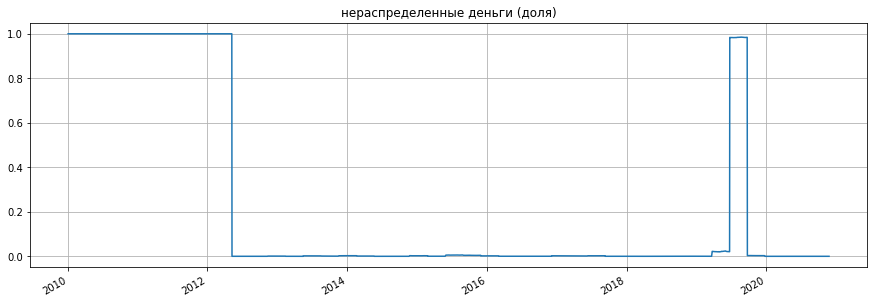

In [15]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot(figsize=(15,5))
plt.grid()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [16]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-11-25  2020-11-25
Risk-free rate       0.00%       0.00%

Total Return         1265.87%    138.21%
Daily Sharpe         1.00        0.46
Daily Sortino        1.65        0.73
CAGR                 27.12%      8.29%
Max Drawdown         -38.49%     -54.38%
Calmar Ratio         0.70        0.15

MTD                  6.79%       25.15%
3m                   -6.86%      24.02%
6m                   46.06%      59.78%
YTD                  60.61%      2.37%
1Y                   67.50%      4.51%
3Y (ann.)            26.52%      -1.29%
5Y (ann.)            27.95%      0.52%
10Y (ann.)           29.88%      9.07%
Since Incep. (ann.)  27.12%      8.29%

Daily Sharpe         1.00        0.46
Daily Sortino        1.65        0.73
Daily Mean (ann.)    27.85%      10.58%
Daily Vol (ann.)     27.73%      22.89%
Daily Skew           0.16       

Енин А.В.

Оренбург